In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from tqdm import tqdm

In [14]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the transformation and load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Load MNIST dataset
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [15]:
# Define the model architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)  # 10 output classes for MNIST digits

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the image
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [16]:
# Initialize two instances of the model
model_continued = Net().to(device)
model_from_scratch = Net().to(device)

# Loss function and optimizers
criterion = nn.CrossEntropyLoss()
optimizer_continued = optim.Adam(model_continued.parameters(), lr=0.001)
optimizer_from_scratch = optim.Adam(model_from_scratch.parameters(), lr=0.001)

In [17]:
# Prepare the data loaders
def prepare_loaders():
    # Get indices of training samples based on the label
    train_indices_1_6 = [i for i, label in enumerate(mnist_train.targets) if label in range(1, 7)]
    train_indices_7_9 = [i for i, label in enumerate(mnist_train.targets) if label in range(7, 10)]

    # Create Subset for 1-6 and 7-9
    subset_train_1_6 = Subset(mnist_train, train_indices_1_6)
    subset_train_7_9 = Subset(mnist_train, train_indices_7_9)

    # Create DataLoader for both subsets
    loader_1_6 = DataLoader(subset_train_1_6, batch_size=64, shuffle=True)
    loader_7_9 = DataLoader(subset_train_7_9, batch_size=64, shuffle=True)

    return loader_1_6, loader_7_9

In [18]:
loader_1_6, loader_7_9 = prepare_loaders()

In [19]:
# Function to train on batches and then predict and train on the next set of batches
def train_and_evaluate_full(model, optimizer, loader_initial, loader_after_shift):
    accuracies = []
    # Train on initial loader
    for data, target in loader_initial:
        data, target = data.to(device), target.to(device)

        model.eval()
        with torch.no_grad():
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct = pred.eq(target.view_as(pred)).sum().item()
            accuracy = correct / data.size(0)
            accuracies.append(accuracy)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

    # Now use the same model to predict and then train on the next set of data
    for data, target in loader_after_shift:
        data, target = data.to(device), target.to(device)
        model.eval()
        with torch.no_grad():
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct = pred.eq(target.view_as(pred)).sum().item()
            accuracy = correct / data.size(0)
            accuracies.append(accuracy)
        model.train()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

    return accuracies

In [20]:
def train_and_evaluate_after_shift(model, optimizer, loader_after_shift):
    accuracies = []
    # Now use the same model to predict and then train on the next set of data
    for data, target in loader_after_shift:
        data, target = data.to(device), target.to(device)
        model.eval()
        with torch.no_grad():
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct = pred.eq(target.view_as(pred)).sum().item()
            accuracy = correct / data.size(0)
            accuracies.append(accuracy)
        model.train()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

    return accuracies

In [21]:
# Train and evaluate the continued model on 1-6 then 7-9
accuracies_continued = train_and_evaluate_full(model_continued, optimizer_continued, loader_1_6, loader_7_9)

# Train and evaluate the from-scratch model on 7-9 only
accuracies_from_scratch = train_and_evaluate_after_shift(model_from_scratch, optimizer_from_scratch, loader_7_9)

# find the shift index
shift_index = len(accuracies_continued) - len(accuracies_from_scratch)

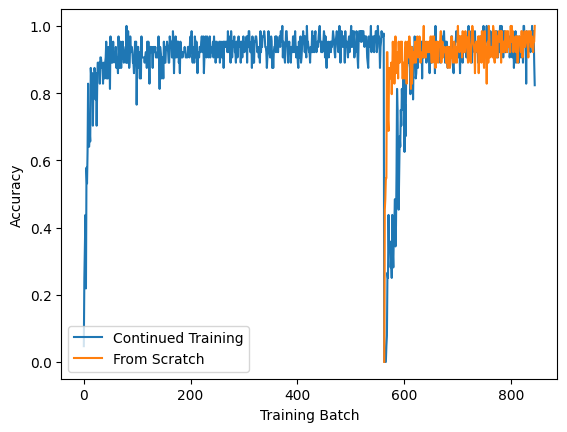

In [22]:

# Plot the results
plt.plot(accuracies_continued, label='Continued Training')
plt.plot(np.arange(shift_index, shift_index + len(accuracies_from_scratch)), accuracies_from_scratch, label='From Scratch')
plt.xlabel('Training Batch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [27]:
def train_and_evaluate_trials(num_trials, loader_1_6, loader_7_9):
    all_accuracies_continued = []
    all_accuracies_from_scratch = []

    for trial in tqdm(range(num_trials)):
        # Reset models for each trial
        model_continued = Net().to(device)
        model_from_scratch = Net().to(device)
        optimizer_continued = optim.Adam(model_continued.parameters(), lr=0.001)
        optimizer_from_scratch = optim.Adam(model_from_scratch.parameters(), lr=0.001)
        
        # Train and evaluate the continued model
        accuracies_continued = train_and_evaluate_full(model_continued, optimizer_continued, loader_1_6, loader_7_9)
        all_accuracies_continued.append(accuracies_continued)
        
        # Train and evaluate the from-scratch model
        accuracies_from_scratch = train_and_evaluate_after_shift(model_from_scratch, optimizer_from_scratch, loader_7_9)
        all_accuracies_from_scratch.append(accuracies_from_scratch)

    # Convert to arrays for easy mean and SEM calculation
    all_accuracies_continued = np.array(all_accuracies_continued)
    all_accuracies_from_scratch = np.array(all_accuracies_from_scratch)

    return all_accuracies_continued, all_accuracies_from_scratch

In [40]:
# Constants
NUM_TRIALS = 10
BATCH_SIZE = 256

# Initialize two instances of the model
model_continued = Net().to(device)
model_from_scratch = Net().to(device)

# Loss function and optimizers
criterion = nn.CrossEntropyLoss()
optimizer_continued = optim.Adam(model_continued.parameters(), lr=0.001)
optimizer_from_scratch = optim.Adam(model_from_scratch.parameters(), lr=0.001)

# Prepare the data loaders
train_indices_1_6 = [i for i, label in enumerate(mnist_train.targets) if label in range(1, 7)]
train_indices_7_9 = [i for i, label in enumerate(mnist_train.targets) if label in range(7, 10)]

# Creating subsets and loaders for the 1-6 and 7-9 digits
subset_train_1_6 = Subset(mnist_train, train_indices_1_6)
subset_train_7_9 = Subset(mnist_train, train_indices_7_9)
loader_1_6 = DataLoader(subset_train_1_6, batch_size=BATCH_SIZE, shuffle=True)
loader_7_9 = DataLoader(subset_train_7_9, batch_size=BATCH_SIZE, shuffle=True)

shift_index = len(loader_1_6)+0.5

# Run training and evaluation over multiple trials and gather data
all_accuracies_continued, all_accuracies_from_scratch = train_and_evaluate_trials(NUM_TRIALS, loader_1_6, loader_7_9)

# Calculate mean and 95% confidence intervals for each batch index
mean_accuracies_continued = all_accuracies_continued.mean(axis=0)
sem_accuracies_continued = stats.sem(all_accuracies_continued, axis=0)
confidence_intervals_continued = stats.t.interval(0.95, NUM_TRIALS-1, loc=mean_accuracies_continued, scale=sem_accuracies_continued)

mean_accuracies_from_scratch = all_accuracies_from_scratch.mean(axis=0)
sem_accuracies_from_scratch = stats.sem(all_accuracies_from_scratch, axis=0)
confidence_intervals_from_scratch = stats.t.interval(0.95, NUM_TRIALS-1, loc=mean_accuracies_from_scratch, scale=sem_accuracies_from_scratch)

100%|██████████| 10/10 [03:26<00:00, 20.65s/it]
/Users/carterblair/opt/anaconda3/envs/liquidDem/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/carterblair/opt/anaconda3/envs/liquidDem/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


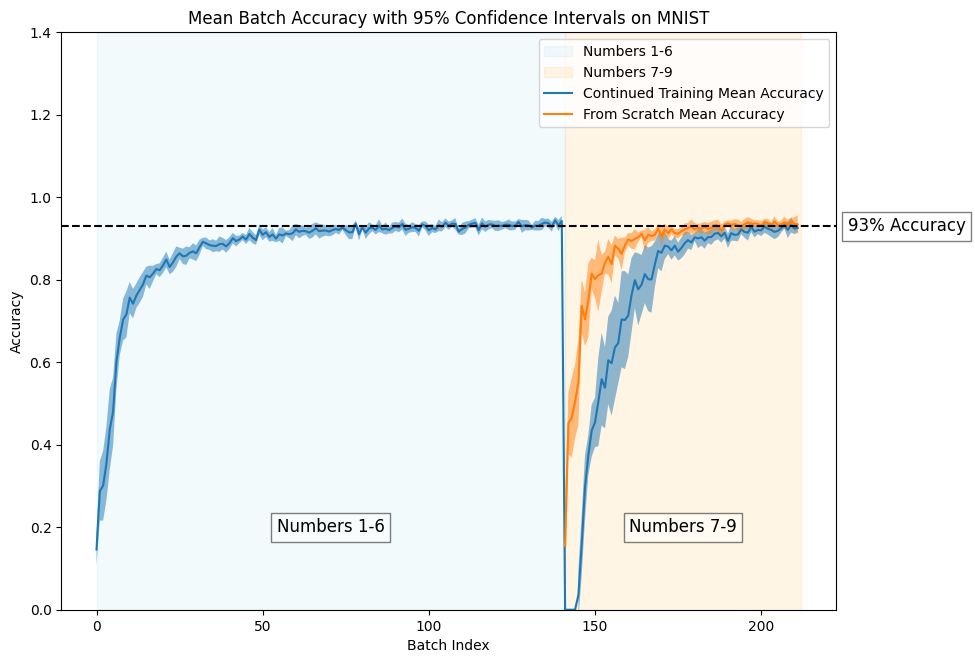

In [58]:
plt.figure(figsize=(10, 7.5))
# Set the y-axis range
plt.ylim(0, 1.4)

# Set the background color for the two phases
plt.axvspan(0, shift_index, color='skyblue', alpha=0.1, label='Numbers 1-6')
plt.axvspan(shift_index, len(mean_accuracies_continued), color='orange', alpha=0.1, label='Numbers 7-9')

# Plot mean accuracy with confidence intervals for continued training
plt.fill_between(range(len(mean_accuracies_continued)), confidence_intervals_continued[0], confidence_intervals_continued[1], alpha=0.5)
plt.plot(mean_accuracies_continued, label='Continued Training Mean Accuracy')

# Plot mean accuracy with confidence intervals for training from scratch
# Note: Since the "from scratch" model is trained after the shift, it starts from there
plt.fill_between(range(shift_index, shift_index + len(mean_accuracies_from_scratch)), confidence_intervals_from_scratch[0], confidence_intervals_from_scratch[1], alpha=0.5)
plt.plot(range(shift_index, shift_index + len(mean_accuracies_from_scratch)), mean_accuracies_from_scratch, label='From Scratch Mean Accuracy')

# Plot a vertical line at the shift index to indicate the shift point
# plt.axvline(x=shift_index, color='k', linestyle='--', label='Shift Index')

# Add text labels for the two phases
plt.text(0.5 * shift_index, 0.2, 'Numbers 1-6', horizontalalignment='center', verticalalignment='center', fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.5))
plt.text(shift_index + 0.5 * (len(mean_accuracies_continued) - shift_index), 0.2, 'Numbers 7-9', horizontalalignment='center', verticalalignment='center', fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.5))

#plot a horizontal line at 1.0
plt.axhline(y=0.93, color='k', linestyle='--')
# add text label for the horizontal line
plt.text(1.15 * len(mean_accuracies_continued), 0.93, '93% Accuracy', horizontalalignment='center', verticalalignment='center', fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.5))

plt.xlabel('Batch Index')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')  # Move the legend to the upper right to avoid blocking the data
plt.title('Mean Batch Accuracy with 95% Confidence Intervals on MNIST')
plt.show()
